In [1]:
import os
import json

In [2]:
if not os.path.exists('/content/data/'):

  api_token = {"username": "prabeshsharma",
                  "key": "e8929420b0f14df13c668815eef404a0"}

  with open('/content/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

  os.system('kaggle datasets download -d scodepy/customer-support-intent-dataset')
  os.makedirs('/content/data/', exist_ok=True)
  os.system('mv /content/customer-support-intent-dataset.zip /content/data/customer-support-intent-dataset.zip')
  os.system('unzip -q /content/data/customer-support-intent-dataset.zip -d /content/data/')
  os.remove('/content/data/customer-support-intent-dataset.zip')

In [3]:
import transformers

In [4]:
print(transformers.__version__)

4.42.4


In [5]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')


import matplotlib.pyplot as plt


from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df = pd.read_csv('/content/data/Bitext_Sample_Customer_Service_Training_Dataset.csv')
df.head()

,utterance,intent,category,tags
0,would it be possible to cancel the order I made?,cancel_order,ORDER,BIP
1,cancelling order,cancel_order,ORDER,BK
2,I need assistance canceling the last order I h...,cancel_order,ORDER,B
3,problem with canceling the order I made,cancel_order,ORDER,B
4,I don't know how to cancel the order I made,cancel_order,ORDER,B


In [7]:
df.drop(['category'], axis=1, inplace=True)
df.head()

,utterance,intent,tags
0,would it be possible to cancel the order I made?,cancel_order,BIP
1,cancelling order,cancel_order,BK
2,I need assistance canceling the last order I h...,cancel_order,B
3,problem with canceling the order I made,cancel_order,B
4,I don't know how to cancel the order I made,cancel_order,B


In [8]:
df.drop(['tags'], axis=1, inplace=True)
df.head()

,utterance,intent
0,would it be possible to cancel the order I made?,cancel_order
1,cancelling order,cancel_order
2,I need assistance canceling the last order I h...,cancel_order
3,problem with canceling the order I made,cancel_order
4,I don't know how to cancel the order I made,cancel_order


In [9]:
df.shape

(6539, 2)

In [10]:
df.isna().sum()

,0
utterance,0
intent,0


In [11]:
df['intent'].unique()

array(['cancel_order', 'change_order', 'change_shipping_address',
       'check_cancellation_fee', 'check_invoice', 'check_payment_methods',
       'check_refund_policy', 'complaint', 'contact_customer_service',
       'contact_human_agent', 'create_account', 'delete_account',
       'delivery_options', 'delivery_period', 'edit_account',
       'get_invoice', 'get_refund', 'newsletter_subscription',
       'payment_issue', 'place_order', 'recover_password',
       'registration_problems', 'review', 'set_up_shipping_address',
       'switch_account', 'track_order', 'track_refund'], dtype=object)

In [12]:
df['count'] = df['utterance'].apply(lambda x: len(x.split()))

In [13]:
df['encoded_intent'] = df['intent'].astype('category').cat.codes

df.head()

,utterance,intent,count,encoded_intent
0,would it be possible to cancel the order I made?,cancel_order,10,0
1,cancelling order,cancel_order,2,0
2,I need assistance canceling the last order I h...,cancel_order,10,0
3,problem with canceling the order I made,cancel_order,7,0
4,I don't know how to cancel the order I made,cancel_order,10,0


In [34]:
df[df['encoded_intent']==8]

,utterance,intent,count,encoded_intent
1948,I need to check at what time customer service ...,contact_customer_service,11,8
1949,I don't know how I can contact customer service,contact_customer_service,9,8
1950,what is your customer service mail?,contact_customer_service,6,8
1951,anyone available at customer service,contact_customer_service,5,8
1952,help me checking at what time I can contact cu...,contact_customer_service,11,8
...,...,...,...,...
2196,I want assistance to talk with customer support,contact_customer_service,8,8
2197,anybody available at customer service,contact_customer_service,5,8
2198,help me to see what hours i can reach customer...,contact_customer_service,11,8
2199,will you show me at what time customer service...,contact_customer_service,11,8


In [14]:
df.tail()

,utterance,intent,count,encoded_intent
6534,I do not know what I have to do to track the r...,track_refund,13,26
6535,check refund status,track_refund,3,26
6536,help me check the refund status,track_refund,6,26
6537,how can I check if there is any updates on my ...,track_refund,12,26
6538,how do I check if there is anything wrong with...,track_refund,12,26


In [15]:
df['intent'].nunique()

27

In [16]:
data_texts = df['utterance'].to_list()

data_labels = df['encoded_intent'].to_list()

In [17]:

train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

# Model defination

In [18]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Fine-tuning with the TFTrainer class

In [20]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=27)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [21]:
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments


# Model initialization
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=27)

# Prepare optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [23]:
history = model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=7,
          batch_size=16,
          validation_data=val_dataset.batch(64))

Epoch 1/7
324/324 [==============================] - 21s 65ms/step - loss: 0.0650 - accuracy: 0.9986 - val_loss: 0.0302 - val_accuracy: 0.9977
Epoch 2/7
324/324 [==============================] - 18s 57ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9977
Epoch 3/7
324/324 [==============================] - 18s 55ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0127 - val_accuracy: 0.9977
Epoch 4/7
324/324 [==============================] - 19s 58ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9977
Epoch 5/7
324/324 [==============================] - 18s 57ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9977
Epoch 6/7
324/324 [==============================] - 19s 58ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9977
Epoch 7/7
324/324 [==============================] - 19s 57ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 0.9977

In [24]:
import matplotlib.pyplot as plt
def plot_graphs(histoy, string):
    plt.plot(histoy.history[string])
    plt.plot(histoy.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

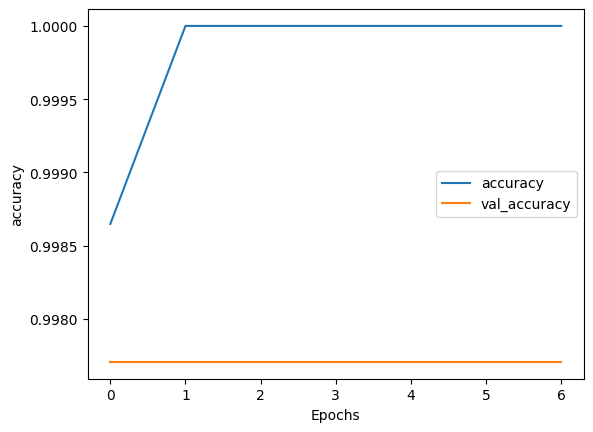

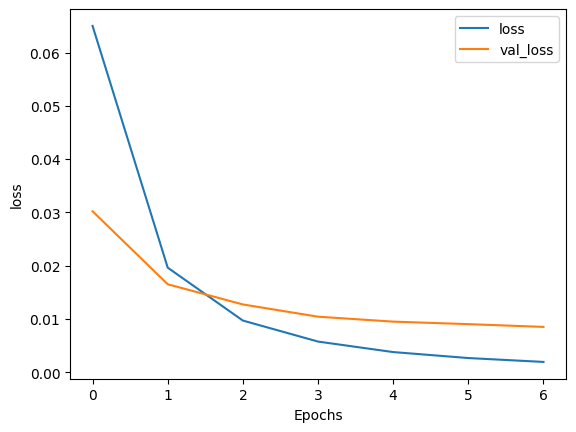

In [25]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [26]:
model.evaluate(val_dataset.batch(64))

21/21 [==============================] - 1s 67ms/step - loss: 0.0085 - accuracy: 0.9977


[0.008505403064191341, 0.997706413269043]

In [29]:
save_directory = "/content/Saved_model"

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/content/Saved_model/tokenizer_config.json',
 '/content/Saved_model/special_tokens_map.json',
 '/content/Saved_model/vocab.txt',
 '/content/Saved_model/added_tokens.json')

In [37]:
df_unique = df.drop_duplicates(subset='encoded_intent')

# Extract the unique intents in the order of their encoded values
unique_ordered_intents = df_unique.sort_values(by='encoded_intent')['intent'].tolist()

print(unique_ordered_intents)

['cancel_order', 'change_order', 'change_shipping_address', 'check_cancellation_fee', 'check_invoice', 'check_payment_methods', 'check_refund_policy', 'complaint', 'contact_customer_service', 'contact_human_agent', 'create_account', 'delete_account', 'delivery_options', 'delivery_period', 'edit_account', 'get_invoice', 'get_refund', 'newsletter_subscription', 'payment_issue', 'place_order', 'recover_password', 'registration_problems', 'review', 'set_up_shipping_address', 'switch_account', 'track_order', 'track_refund']


# Loading the model

In [30]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/Saved_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/Saved_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
intent_class_names= ['cancel_order', 'change_order', 'change_shipping_address',
                  'check_cancellation_fee', 'check_invoice', 'check_payment_methods',
                  'check_refund_policy', 'complaint', 'contact_customer_service',
                  'contact_human_agent', 'create_account', 'delete_account',
                  'delivery_options', 'delivery_period', 'edit_account',
                  'get_invoice', 'get_refund', 'newsletter_subscription',
                  'payment_issue', 'place_order', 'recover_password', 'registration_problems',
                  'review', 'set_up_shipping_address', 'switch_account', 'track_order', 'track_refund']


In [55]:
# test_text = test_texts[50]

test_text = 'I forget my password'

In [56]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

predicted_class_name = intent_class_names[prediction_value]
predicted_class_name

'recover_password'